In [153]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F



In [154]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [155]:
data = Digits()
data[0].shape
data

In [156]:
class RoundStraightThrough(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone()


In [157]:
def log_min_exp(a, b):
    # Numerically stable log(exp(a) - exp(b)).
    max_ab = torch.maximum(a, b)
    min_ab = torch.minimum(a, b)
    return max_ab + torch.log1p(-torch.exp(min_ab - max_ab))

In [158]:
def log_integer_probability(x, mean, logscale):
    logscale = torch.clamp(logscale, -5, 5)
    scale = torch.exp(logscale)
    logp = log_min_exp(
        F.logsigmoid(((x + 0.5) - mean) / scale),
        F.logsigmoid(((x - 0.5) - mean) / scale)
    )
    return logp

In [159]:
D = 64   # input dimension
M = 256  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 100 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped
nett = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                                     nn.Linear(M, M), nn.LeakyReLU(),
                                     nn.Linear(M, D // 2))
netts = [nett]

In [160]:
class IDF(nn.Module):
    def __init__(self, netts, num_flows, D=2):
        super().__init__()
        if len(netts) == 1:
            self.t = nn.ModuleList([netts[0]() for _ in range(num_flows)])
            self.idf_git = 1

        elif len(netts) == 4:
            self.t_a = nn.ModuleList([netts[0]() for _ in range(num_flows)])
            self.t_b = nn.ModuleList([netts[1]() for _ in range(num_flows)])
            self.t_c = nn.ModuleList([netts[2]() for _ in range(num_flows)])
            self.t_d = nn.ModuleList([netts[3]() for _ in range(num_flows)])
            self.idf_git = 1

        else:
            raise ValueError(f"The transformation net need to be either 1 or 4. The provided net contains {len(netts)} layers.")

        self.num_flows = num_flows
        self.round = RoundStraightThrough.apply

        self.mean = nn.Parameter(torch.zeros(1, D))
        self.logscale = nn.Parameter(torch.ones(1, D))

        self.D = D

    def coupling(self, x, index, forward=True):
        if self.idf_git == 1:
            (xa, xb) = torch.chunk(x, 2, 1)

            if forward:
                yb = xb + self.round(self.t[index](xa))
            else:
                yb = xb - self.round(self.t[index](xa))
            return torch.cat((xa, yb), 1)
        elif self.idf_git == 4:
            (xa, xb, xc, xd) = torch.chunk(x, 4, 1)
            if forward:
                ya = xa + self.round(self.t_a[index](torch.cat((xb, xc, xd), 1)))
                yb = xb + self.round(self.t_b[index](torch.cat((ya, xc, xd), 1)))
                yc = xc + self.round(self.t_c[index](torch.cat((ya, yb, xd), 1)))
                yd = xd + self.round(self.t_d[index](torch.cat((ya, yb, yc), 1)))
            else:
                yd = xd - self.round(self.t_d[index](torch.cat((xa, xb, xc), 1)))
                yc = xc - self.round(self.t_c[index](torch.cat((xa, xb, yd), 1)))
                yb = xb - self.round(self.t_b[index](torch.cat((xa, yc, yd), 1)))
                ya = xa - self.round(self.t_a[index](torch.cat((yb, yc, yd), 1)))

            return torch.cat((ya, yb, yc, yd), 1)

    def permute(self, x):
        return x.flip(1)

    def f(self, x):
        z = x
        for i in range(self.num_flows):
            z = self.coupling(z, i, forward=True)
            z = self.permute(z)
        return z

    def f_inv(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x = self.coupling(x, i, forward=False)

        return x

    def log_prior(self, x):
        x = torch.clamp(x, -20, 20)
        log_p = log_integer_probability(x, self.mean, self.logscale)
        return log_p.sum(1)

    def forward(self, x, reduction="avg"):
        z = self.f(x)
        if reduction == 'sum':
            return -self.log_prior(z).sum()
        else:
            return -self.log_prior(z).mean()

    def sample(self, batch_size, int_max=100):
        z = self.prior_sample(batch_size=batch_size, D=self.D)
        x = self.f_inv(z)
        return x  # shape: (batch_size, D)

    def prior_sample(self, batch_size, D=2):
        y = torch.rand(batch_size, self.D)
        x = torch.exp(self.logscale) * torch.log(y / (1. - y)) + self.mean
        return torch.round(x)

In [161]:
IDF(netts, 1)

IDF(
  (t): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=32, bias=True)
    )
  )
)

In [162]:
from torchinfo import summary

num_flows = 8

idf_git = 4

if idf_git == 1:
    nett = lambda: nn.Sequential(
        nn.Linear(D // 2, M),
        nn.LeakyReLU(),
        nn.Linear(M, M),
        nn.LeakyReLU(),
        nn.Linear(M, D // 2),
    )
    netts = [nett]

elif idf_git == 4:
    nett_a = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M),
        nn.LeakyReLU(),
        nn.Linear(M, M),
        nn.LeakyReLU(),
        nn.Linear(M, D // 4),
    )

    nett_b = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M),
        nn.LeakyReLU(),
        nn.Linear(M, M),
        nn.LeakyReLU(),
        nn.Linear(M, D // 4),
    )

    nett_c = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M),
        nn.LeakyReLU(),
        nn.Linear(M, M),
        nn.LeakyReLU(),
        nn.Linear(M, D // 4),
    )

    nett_d = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M),
        nn.LeakyReLU(),
        nn.Linear(M, M),
        nn.LeakyReLU(),
        nn.Linear(M, D // 4),
    )

    netts = [nett_a, nett_b, nett_c, nett_d]

model = IDF(netts, num_flows, D=D)

model.idf_git = 4  # ensure 4-way coupling path is used

summary(
    model=model,
    input_size=(1, D),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
IDF (IDF)                                [1, 64]              --                   128                  True
├─ModuleList (t_a)                       --                   --                   (recursive)          True
│    └─Sequential (0)                    [1, 48]              [1, 16]              --                   True
│    │    └─Linear (0)                   [1, 48]              [1, 256]             12,544               True
│    │    └─LeakyReLU (1)                [1, 256]             [1, 256]             --                   --
│    │    └─Linear (2)                   [1, 256]             [1, 256]             65,792               True
│    │    └─LeakyReLU (3)                [1, 256]             [1, 256]             --                   --
│    │    └─Linear (4)                   [1, 256]             [1, 16]              4,112                True
├─ModuleList (t_b)

In [163]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + ".model")

    model_best.eval()
    loss = 0.0
    N = 0.0
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction="sum")
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f"FINAL LOSS: nll={loss}")
    else:
        print(f"Epoch: {epoch}, val nll={loss}")

    return loss

In [164]:
from torch.utils.data import DataLoader

train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [165]:
from tqdm.auto import tqdm
def training(name, model, device="cpu"):
    nll_val = []
    best_nll = 1000.0
    patience = 0
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in tqdm(range(num_epochs)):
        for x in tqdm(training_loader):
            loss = model.forward(x)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        loss_val = evaluation(val_loader, model_best=model, epoch=epoch)
        nll_val.append(loss_val)  # save for plotting
        print(loss_val)
    nll_val = np.asarray(nll_val)

    return nll_val

In [166]:
training(name="IDF", model=model)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<03:42,  2.24s/it]

Epoch: 0, val nll=428.8242494419643
428.8242494419643


  2%|▏         | 2/100 [00:07<06:09,  3.77s/it]

Epoch: 1, val nll=363.20169921875
363.20169921875


  3%|▎         | 3/100 [00:10<05:48,  3.60s/it]

Epoch: 2, val nll=327.25644252232144
327.25644252232144


  4%|▍         | 4/100 [00:16<07:18,  4.57s/it]

Epoch: 3, val nll=307.4101255580357
307.4101255580357


  5%|▌         | 5/100 [00:18<05:49,  3.68s/it]

Epoch: 4, val nll=296.3106361607143
296.3106361607143


  6%|▌         | 6/100 [00:20<04:42,  3.00s/it]

Epoch: 5, val nll=289.9906919642857
289.9906919642857


  7%|▋         | 7/100 [00:22<04:08,  2.67s/it]

Epoch: 6, val nll=286.2998353794643
286.2998353794643


  8%|▊         | 8/100 [00:25<04:09,  2.72s/it]

Epoch: 7, val nll=284.0653989955357
284.0653989955357


  9%|▉         | 9/100 [00:30<05:18,  3.49s/it]

Epoch: 8, val nll=282.6401060267857
282.6401060267857


 10%|█         | 10/100 [00:33<05:11,  3.46s/it]

Epoch: 9, val nll=281.66186104910713
281.66186104910713


 11%|█         | 11/100 [00:35<04:31,  3.05s/it]

Epoch: 10, val nll=280.92578125
280.92578125


 12%|█▏        | 12/100 [00:38<04:14,  2.90s/it]

Epoch: 11, val nll=280.31515345982143
280.31515345982143


 13%|█▎        | 13/100 [00:47<06:48,  4.70s/it]

Epoch: 12, val nll=279.76327845982144
279.76327845982144


 14%|█▍        | 14/100 [00:52<06:53,  4.81s/it]

Epoch: 13, val nll=279.23217354910713
279.23217354910713


 15%|█▌        | 15/100 [00:55<06:15,  4.41s/it]

Epoch: 14, val nll=278.70053013392857
278.70053013392857


 16%|█▌        | 16/100 [00:57<05:11,  3.71s/it]

Epoch: 15, val nll=278.1562193080357
278.1562193080357


 17%|█▋        | 17/100 [00:59<04:17,  3.10s/it]

Epoch: 16, val nll=277.59249720982143
277.59249720982143


 18%|█▊        | 18/100 [01:01<03:40,  2.69s/it]

Epoch: 17, val nll=277.00546595982144
277.00546595982144


 19%|█▉        | 19/100 [01:02<03:08,  2.33s/it]

Epoch: 18, val nll=276.39279017857143
276.39279017857143


 20%|██        | 20/100 [01:04<02:46,  2.08s/it]

Epoch: 19, val nll=275.7529296875
275.7529296875


 21%|██        | 21/100 [01:05<02:30,  1.90s/it]

Epoch: 20, val nll=275.08468470982143
275.08468470982143


 22%|██▏       | 22/100 [01:07<02:27,  1.90s/it]

Epoch: 21, val nll=274.38684151785714
274.38684151785714


 23%|██▎       | 23/100 [01:09<02:35,  2.02s/it]

Epoch: 22, val nll=273.65847935267857
273.65847935267857


 24%|██▍       | 24/100 [01:12<02:44,  2.16s/it]

Epoch: 23, val nll=272.8984068080357
272.8984068080357


 25%|██▌       | 25/100 [01:14<02:48,  2.25s/it]

Epoch: 24, val nll=272.1053445870536
272.1053445870536


 26%|██▌       | 26/100 [01:17<02:52,  2.34s/it]

Epoch: 25, val nll=271.27810965401784
271.27810965401784


 27%|██▋       | 27/100 [01:20<03:02,  2.50s/it]

Epoch: 26, val nll=270.41524972098216
270.41524972098216


 28%|██▊       | 28/100 [01:22<03:01,  2.51s/it]

Epoch: 27, val nll=269.5151060267857
269.5151060267857


 29%|██▉       | 29/100 [01:25<02:55,  2.48s/it]

Epoch: 28, val nll=268.576142578125
268.576142578125


 30%|███       | 30/100 [01:27<02:43,  2.33s/it]

Epoch: 29, val nll=267.59640206473216
267.59640206473216


 31%|███       | 31/100 [01:29<02:33,  2.22s/it]

Epoch: 30, val nll=266.5738546316964
266.5738546316964


 32%|███▏      | 32/100 [01:31<02:32,  2.24s/it]

Epoch: 31, val nll=265.50634765625
265.50634765625


 33%|███▎      | 33/100 [01:33<02:33,  2.30s/it]

Epoch: 32, val nll=264.39135602678573
264.39135602678573


 34%|███▍      | 34/100 [01:36<02:31,  2.30s/it]

Epoch: 33, val nll=263.22631696428573
263.22631696428573


 35%|███▌      | 35/100 [01:38<02:30,  2.31s/it]

Epoch: 34, val nll=262.0081766183036
262.0081766183036


 36%|███▌      | 36/100 [01:40<02:21,  2.21s/it]

Epoch: 35, val nll=260.7337625558036
260.7337625558036


 37%|███▋      | 37/100 [01:42<02:17,  2.18s/it]

Epoch: 36, val nll=259.399384765625
259.399384765625


 38%|███▊      | 38/100 [01:44<02:16,  2.20s/it]

Epoch: 37, val nll=258.0010072544643
258.0010072544643


 39%|███▉      | 39/100 [01:46<02:12,  2.17s/it]

Epoch: 38, val nll=256.53433314732143
256.53433314732143


 40%|████      | 40/100 [01:49<02:08,  2.14s/it]

Epoch: 39, val nll=254.99424386160715
254.99424386160715


 41%|████      | 41/100 [01:51<02:06,  2.14s/it]

Epoch: 40, val nll=253.37510881696429
253.37510881696429


 42%|████▏     | 42/100 [01:53<02:02,  2.12s/it]

Epoch: 41, val nll=251.67056361607143
251.67056361607143


 43%|████▎     | 43/100 [01:55<01:59,  2.09s/it]

Epoch: 42, val nll=249.87362723214287
249.87362723214287


 44%|████▍     | 44/100 [01:57<02:00,  2.15s/it]

Epoch: 43, val nll=247.97586356026787
247.97586356026787


 45%|████▌     | 45/100 [01:59<01:59,  2.18s/it]

Epoch: 44, val nll=245.96810825892857
245.96810825892857


 46%|████▌     | 46/100 [02:01<01:56,  2.16s/it]

Epoch: 45, val nll=243.8393861607143
243.8393861607143


 47%|████▋     | 47/100 [02:04<01:53,  2.14s/it]

Epoch: 46, val nll=241.57735909598213
241.57735909598213


 48%|████▊     | 48/100 [02:06<01:51,  2.14s/it]

Epoch: 47, val nll=239.16713169642858
239.16713169642858


 49%|████▉     | 49/100 [02:08<01:46,  2.10s/it]

Epoch: 48, val nll=236.591572265625
236.591572265625


 50%|█████     | 50/100 [02:10<01:42,  2.05s/it]

Epoch: 49, val nll=233.82996930803571
233.82996930803571


 51%|█████     | 51/100 [02:12<01:41,  2.07s/it]

Epoch: 50, val nll=230.85755998883928
230.85755998883928


 52%|█████▏    | 52/100 [02:14<01:41,  2.11s/it]

Epoch: 51, val nll=227.64416713169643
227.64416713169643


 53%|█████▎    | 53/100 [02:16<01:39,  2.12s/it]

Epoch: 52, val nll=224.15260463169642
224.15260463169642


 54%|█████▍    | 54/100 [02:18<01:36,  2.10s/it]

Epoch: 53, val nll=220.336318359375
220.336318359375


 55%|█████▌    | 55/100 [02:20<01:34,  2.09s/it]

Epoch: 54, val nll=216.13607700892857
216.13607700892857


 56%|█████▌    | 56/100 [02:22<01:30,  2.06s/it]

Epoch: 55, val nll=211.47495814732142
211.47495814732142


 57%|█████▋    | 57/100 [02:24<01:30,  2.11s/it]

Epoch: 56, val nll=206.25094447544643
206.25094447544643


 58%|█████▊    | 58/100 [02:27<01:38,  2.34s/it]

Epoch: 57, val nll=200.32472237723215
200.32472237723215


 59%|█████▉    | 59/100 [02:30<01:40,  2.46s/it]

Epoch: 58, val nll=193.50062639508928
193.50062639508928


 60%|██████    | 60/100 [02:32<01:35,  2.40s/it]

Epoch: 59, val nll=185.4926157924107
185.4926157924107


 61%|██████    | 61/100 [02:34<01:30,  2.32s/it]

Epoch: 60, val nll=175.86438197544643
175.86438197544643


 62%|██████▏   | 62/100 [02:36<01:25,  2.24s/it]

Epoch: 61, val nll=163.91603097098215
163.91603097098215


 63%|██████▎   | 63/100 [02:38<01:20,  2.17s/it]

Epoch: 62, val nll=148.46949776785715
148.46949776785715


 64%|██████▍   | 64/100 [02:41<01:17,  2.15s/it]

Epoch: 63, val nll=127.53649832589285
127.53649832589285


 65%|██████▌   | 65/100 [02:43<01:16,  2.18s/it]

Epoch: 64, val nll=98.7031787109375
98.7031787109375


 66%|██████▌   | 66/100 [02:45<01:14,  2.20s/it]

Epoch: 65, val nll=65.11521205357143
65.11521205357143


 67%|██████▋   | 67/100 [02:47<01:11,  2.17s/it]

Epoch: 66, val nll=37.71305838448661
37.71305838448661


 68%|██████▊   | 68/100 [02:49<01:07,  2.11s/it]

Epoch: 67, val nll=19.618003801618304
19.618003801618304


 69%|██████▉   | 69/100 [02:51<01:03,  2.05s/it]

Epoch: 68, val nll=9.955071498325893
9.955071498325893


 70%|███████   | 70/100 [02:53<01:01,  2.03s/it]

Epoch: 69, val nll=5.431037946428572
5.431037946428572


 71%|███████   | 71/100 [02:55<01:00,  2.08s/it]

Epoch: 70, val nll=3.293762664794922
3.293762664794922


 72%|███████▏  | 72/100 [02:57<00:58,  2.10s/it]

Epoch: 71, val nll=2.190847647530692
2.190847647530692


 73%|███████▎  | 73/100 [02:59<00:56,  2.09s/it]

Epoch: 72, val nll=1.5625252750941685
1.5625252750941685


 74%|███████▍  | 74/100 [03:02<00:54,  2.09s/it]

Epoch: 73, val nll=1.173415309361049
1.173415309361049


 75%|███████▌  | 75/100 [03:04<00:51,  2.07s/it]

Epoch: 74, val nll=0.9160738045828684
0.9160738045828684


 76%|███████▌  | 76/100 [03:05<00:48,  2.03s/it]

Epoch: 75, val nll=0.7368809073311942
0.7368809073311942


 77%|███████▋  | 77/100 [03:09<00:54,  2.38s/it]

Epoch: 76, val nll=0.6068956865583147
0.6068956865583147


 78%|███████▊  | 78/100 [03:11<00:52,  2.39s/it]

Epoch: 77, val nll=0.5094394683837891
0.5094394683837891


 79%|███████▉  | 79/100 [03:14<00:50,  2.39s/it]

Epoch: 78, val nll=0.4343635450090681
0.4343635450090681


 80%|████████  | 80/100 [03:16<00:50,  2.52s/it]

Epoch: 79, val nll=0.3752057920183454
0.3752057920183454


 81%|████████  | 81/100 [03:19<00:46,  2.44s/it]

Epoch: 80, val nll=0.32769310542515345
0.32769310542515345


 82%|████████▏ | 82/100 [03:21<00:42,  2.39s/it]

Epoch: 81, val nll=0.2889053508213588
0.2889053508213588


 83%|████████▎ | 83/100 [03:23<00:41,  2.43s/it]

Epoch: 82, val nll=0.25679075922284805
0.25679075922284805


 84%|████████▍ | 84/100 [03:26<00:38,  2.40s/it]

Epoch: 83, val nll=0.22987283979143416
0.22987283979143416


 85%|████████▌ | 85/100 [03:28<00:34,  2.32s/it]

Epoch: 84, val nll=0.20706590924944196
0.20706590924944196


 86%|████████▌ | 86/100 [03:30<00:31,  2.25s/it]

Epoch: 85, val nll=0.18755663871765138
0.18755663871765138


 87%|████████▋ | 87/100 [03:32<00:29,  2.24s/it]

Epoch: 86, val nll=0.17072548185076034
0.17072548185076034


 88%|████████▊ | 88/100 [03:35<00:27,  2.31s/it]

Epoch: 87, val nll=0.15609365735735212
0.15609365735735212


 89%|████████▉ | 89/100 [03:37<00:25,  2.29s/it]

Epoch: 88, val nll=0.14328600474766323
0.14328600474766323


 90%|█████████ | 90/100 [03:39<00:22,  2.27s/it]

Epoch: 89, val nll=0.13200527531760078
0.13200527531760078


 91%|█████████ | 91/100 [03:42<00:23,  2.60s/it]

Epoch: 90, val nll=0.12201292106083461
0.12201292106083461


 92%|█████████▏| 92/100 [03:46<00:23,  2.88s/it]

Epoch: 91, val nll=0.11311590739658901
0.11311590739658901


 93%|█████████▎| 93/100 [03:48<00:18,  2.67s/it]

Epoch: 92, val nll=0.10515676975250245
0.10515676975250245


 94%|█████████▍| 94/100 [03:51<00:16,  2.68s/it]

Epoch: 93, val nll=0.09800541469029019
0.09800541469029019


 95%|█████████▌| 95/100 [03:54<00:14,  2.83s/it]

Epoch: 94, val nll=0.09155400139944894
0.09155400139944894


 96%|█████████▌| 96/100 [04:01<00:16,  4.05s/it]

Epoch: 95, val nll=0.08571240356990269
0.08571240356990269


 97%|█████████▋| 97/100 [04:04<00:11,  3.82s/it]

Epoch: 96, val nll=0.08040469782693045
0.08040469782693045


 98%|█████████▊| 98/100 [04:07<00:07,  3.55s/it]

Epoch: 97, val nll=0.07556659766605922
0.07556659766605922


 99%|█████████▉| 99/100 [04:10<00:03,  3.24s/it]

Epoch: 98, val nll=0.0711433812550136
0.0711433812550136


100%|██████████| 100/100 [04:13<00:00,  2.53s/it]

Epoch: 99, val nll=0.06708813462938581
0.06708813462938581


array([4.28824249e+02, 3.63201699e+02, 3.27256443e+02, 3.07410126e+02,
       2.96310636e+02, 2.89990692e+02, 2.86299835e+02, 2.84065399e+02,
       2.82640106e+02, 2.81661861e+02, 2.80925781e+02, 2.80315153e+02,
       2.79763278e+02, 2.79232174e+02, 2.78700530e+02, 2.78156219e+02,
       2.77592497e+02, 2.77005466e+02, 2.76392790e+02, 2.75752930e+02,
       2.75084685e+02, 2.74386842e+02, 2.73658479e+02, 2.72898407e+02,
       2.72105345e+02, 2.71278110e+02, 2.70415250e+02, 2.69515106e+02,
       2.68576143e+02, 2.67596402e+02, 2.66573855e+02, 2.65506348e+02,
       2.64391356e+02, 2.63226317e+02, 2.62008177e+02, 2.60733763e+02,
       2.59399385e+02, 2.58001007e+02, 2.56534333e+02, 2.54994244e+02,
       2.53375109e+02, 2.51670564e+02, 2.49873627e+02, 2.47975864e+02,
       2.45968108e+02, 2.43839386e+02, 2.41577359e+02, 2.39167132e+02,
       2.36591572e+02, 2.33829969e+02, 2.30857560e+02, 2.27644167e+02,
       2.24152605e+02, 2.20336318e+02, 2.16136077e+02, 2.11474958e+02,
      

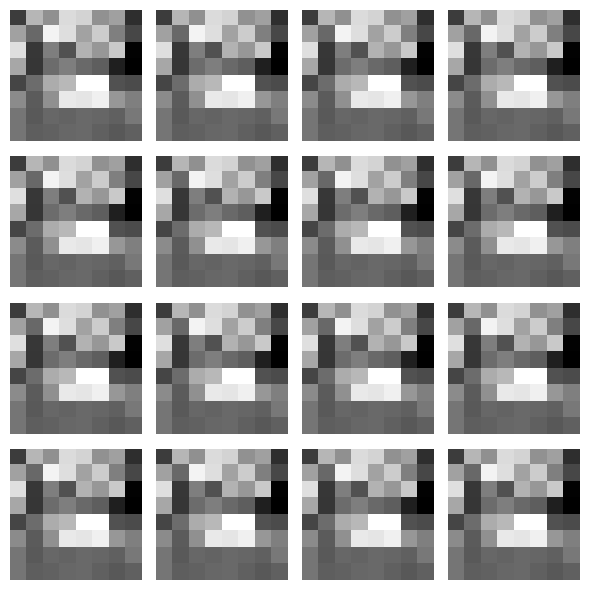

In [167]:

# Generate and visualize samples
model.eval()
with torch.no_grad():
    raw_samples = model.sample(batch_size=16).detach().cpu()
if raw_samples.dim() == 3:
    samples = raw_samples[:, 0, :]
else:
    samples = raw_samples
samples_np = samples.numpy()
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for ax, img in zip(axes.flat, samples_np):
    ax.imshow(img.reshape(8, 8), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()
